<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 360 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [1]:
%pip install statstests

In [2]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
import warnings
from tqdm.auto import tqdm
from sklearn.exceptions import NotFittedError
from typing import Dict, List, Tuple, Optional
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin


# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)


In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')
df.shape

(14363, 26)

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [5]:
df.head(10)

,date_window,transactions,frauds,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,...,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,median_credit_limit,max_credit_limit,target_city_0,target_city_1,target_description_0,target_description_2,previous_frauds
0,2010-01-01 00:00:00,1.32,0,0.039623,0.27022,30,54.628788,101,0.000,22.462932,...,1,3.946970,8,16.065136,76.343,1.0,0.0,1.0,0.0,0
1,2010-01-01 06:00:00,8.13,0,0.035350,1.15361,28,55.579336,101,0.000,24.074888,...,1,3.979090,9,15.062614,70.187,1.0,0.0,1.0,0.0,0
2,2010-01-01 12:00:00,7.66,0,0.053246,1.30971,28,56.356397,99,0.000,24.248730,...,1,3.881201,9,15.741868,125.723,1.0,0.0,1.0,0.0,0
3,2010-01-01 18:00:00,4.80,1,0.052066,0.69230,30,55.416667,98,0.000,24.630685,...,1,3.831250,8,14.942865,96.637,1.0,0.0,1.0,0.0,0
4,2010-01-02 00:00:00,1.11,0,0.077234,0.84396,32,55.333333,90,10.091,22.904180,...,1,3.900901,8,14.475153,57.294,1.0,0.0,1.0,0.0,1
5,2010-01-02 06:00:00,6.79,0,0.050233,1.41114,29,55.393225,101,0.000,24.209027,...,1,3.918999,8,15.222744,141.391,1.0,0.0,1.0,0.0,0
6,2010-01-02 12:00:00,7.30,0,0.050895,0.43300,29,55.616438,99,0.000,24.413727,...,1,3.909589,9,15.059014,125.723,1.0,0.0,1.0,0.0,0
7,2010-01-02 18:00:00,3.69,0,0.055165,0.83729,28,54.284553,99,0.000,22.062108,...,1,3.953930,8,14.885263,96.637,1.0,0.0,1.0,0.0,0
8,2010-01-03 00:00:00,1.16,0,0.056810,0.43672,28,54.974138,90,0.000,23.238664,...,1,4.060345,8,15.231552,47.833,1.0,0.0,1.0,0.0,0
9,2010-01-03 06:00:00,8.44,0,0.040478,0.74826,28,54.255924,101,0.000,23.778004,...,1,3.960900,9,15.225850,130.971,1.0,0.0,1.0,0.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14363 entries, 0 to 14362
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date_window               14363 non-null  datetime64[ns]
 1   transactions              14363 non-null  float64       
 2   frauds                    14363 non-null  int32         
 3   median_amount             14363 non-null  float64       
 4   max_amount                14363 non-null  float64       
 5   min_current_age           14363 non-null  int64         
 6   median_current_age        14363 non-null  float64       
 7   max_current_age           14363 non-null  int64         
 8   min_per_capita_income     14363 non-null  float64       
 9   median_per_capita_income  14363 non-null  float64       
 10  max_per_capita_income     14363 non-null  float64       
 11  min_total_debt            14363 non-null  float64       
 12  median_total_debt 

In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date_window,14363,2014-12-01 10:40:50.797187328,2010-01-01 00:00:00,2012-06-16 21:00:00,2014-12-01 12:00:00,2017-05-17 03:00:00,2019-10-31 18:00:00,NaN
transactions,14363.0,5.898617,0.01,1.77,5.66,8.95,11.22,3.329053
frauds,14363.0,0.894103,0.0,0.0,0.0,0.0,35.0,2.285803
median_amount,14363.0,0.054108,0.030616,0.04841,0.054424,0.059521,1.15331,0.016098
max_amount,14363.0,0.866673,0.10213,0.523915,0.81813,1.09447,6.61344,0.430993
min_current_age,14363.0,25.68022,23.0,24.0,25.0,27.0,55.0,1.984802
median_current_age,14363.0,53.933532,26.0,53.289989,53.992647,54.612501,68.666667,1.100665
max_current_age,14363.0,98.307596,26.0,98.0,99.0,101.0,101.0,3.179176
min_per_capita_income,14363.0,1.711871,0.0,0.0,0.0,0.0,30.307,3.752219
median_per_capita_income,14363.0,23.78235,9.71,23.440365,23.869233,24.22623,37.597,0.697543


## Implementação de Modelos

In [8]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [9]:
y.shape

(14363,)

In [10]:
y.value_counts().sort_index()

,count
frauds,
0,11006
1,975
2,646
3,393
4,304
5,257
6,177
7,163
8,111


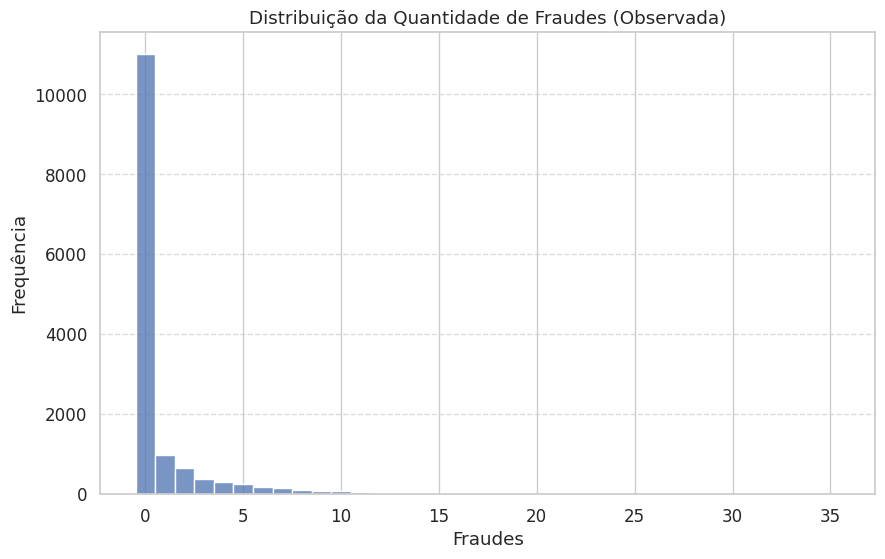

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 1.063733
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.056997
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 44


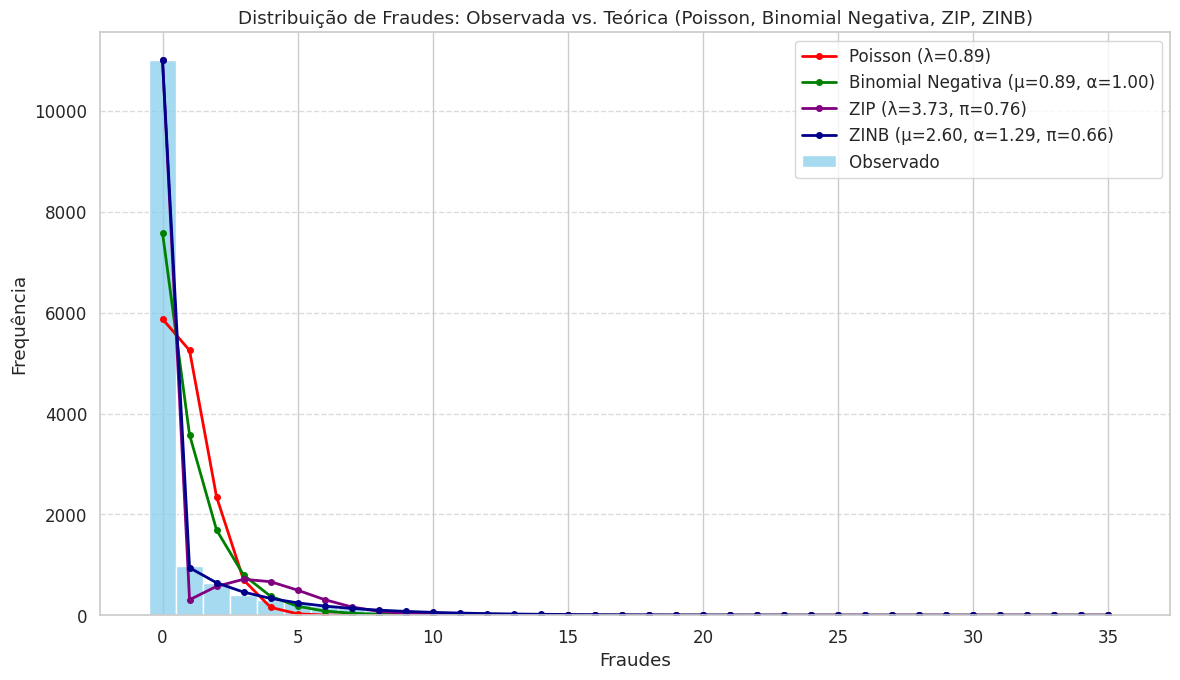

In [12]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

#### Comparação estatistica entre modelos

In [13]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Plotar a comparação entre modelos atraves do LogLik

In [14]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plotar os resíduos do modelo

In [15]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

#### Test de Vuong para Inflação de Zeros

In [16]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Algoritmo Stepwise para modelos Zero Inflated

In [17]:
class SimpleStepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor stepwise simplificado para modelos Zero-Inflated com validação de convergência.

    Esta versão simplificada foca em:
    - Seleção stepwise eficiente
    - Validação rigorosa de convergência do modelo
    - Critérios de parada inteligentes
    - Código limpo e manutenível

    Principais melhorias:
    - Validação de convergência em cada iteração
    - Detecção automática de instabilidade numérica
    - Early stopping baseado em múltiplos critérios
    - Código 10x mais simples que a versão original
    """

    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-6,
                 convergence_patience=3,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 require_exog_features=True,
                 require_inf_features=True,
                 try_initialize_startup=5,
                 random_state=None,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        require_exog_features : bool, default=True
            Se deve exigir pelo menos uma feature no componente exógeno.
            - True: Componente exógeno deve ter ao menos uma feature além da constante
            - False: Componente exógeno pode ter apenas constante

        require_inf_features : bool, default=True
            Se deve exigir pelo menos uma feature no componente de inflação.
            - True: Componente de inflação deve ter ao menos uma feature além da constante
            - False: Componente de inflação pode ter apenas constante

        try_initialize_startup : int, default=3
            Número de tentativas de inicialização com diferentes ordenações de features
            quando os requisitos de componentes não podem ser satisfeitos na primeira tentativa.
            Estratégias incluem: ordem original, aleatória, por correlação com target.

        random_state : int, optional, default=None
            Semente para reprodutibilidade nas tentativas de inicialização aleatórias.
            Se None, não define semente fixa.

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.require_exog_features = require_exog_features
        self.require_inf_features = require_inf_features
        self.try_initialize_startup = try_initialize_startup
        self.random_state = random_state
        self.verbose = verbose

        # Configurar seed se especificado
        if random_state is not None:
            np.random.seed(random_state)

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str]) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(
                    maxiter=self.max_fit_iterations,
                    method=self.method,
                    cov_type=self.cov_type,
                    disp=False,
                    full_output=True  # Para obter informações detalhadas de convergência
                )

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_component_requirements(self, exog_features: List[str],
                                       inf_features: List[str]) -> bool:
        """
        Valida se os componentes atendem aos requisitos mínimos de features.

        Parameters:
        -----------
        exog_features : List[str]
            Lista de features do componente exógeno (sem contar constante)
        inf_features : List[str]
            Lista de features do componente de inflação (sem contar constante)

        Returns:
        --------
        bool : True se requisitos são atendidos, False caso contrário
        """
        # Verificar componente exógeno
        if self.require_exog_features and len(exog_features) == 0:
            if self.verbose:
                print("   ✗ Exogenous component requirement not met (no features)")
            return False

        # Verificar componente de inflação
        if self.require_inf_features and len(inf_features) == 0:
            if self.verbose:
                print("   ✗ Inflation component requirement not met (no features)")
            return False

        return True

    def _validate_dataset_compatibility(self, X: pd.DataFrame) -> None:
        """
        Valida se o dataset é compatível com os requisitos de componentes.

        Parameters:
        -----------
        X : pd.DataFrame
            Dataset com features

        Raises:
        -------
        ValueError : Se dataset é incompatível com requisitos
        """
        n_features = X.shape[1]
        required_components = sum([self.require_exog_features, self.require_inf_features])

        if required_components > n_features:
            raise ValueError(
                f"Dataset has only {n_features} features but requires {required_components} "
                f"components with features. Need at least {required_components} features "
                f"for require_exog_features={self.require_exog_features} and "
                f"require_inf_features={self.require_inf_features}."
            )

        if self.verbose and required_components > 0:
            print(f"Dataset compatibility: {n_features} features available, "
                  f"{required_components} components require features")

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str]) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Verificar se configuração atende requisitos de componentes
            if not self._validate_component_requirements(test_exog, test_inf):
                if self.verbose:
                    print(f"      Skipping: doesn't meet component requirements")
                continue

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            # Verificar se remoção violaria requisitos de componentes
            if not self._validate_component_requirements(test_exog, test_inf):
                if self.verbose:
                    print(f"      Cannot remove {feature}: would violate component requirements")
                continue

            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _rank_features_by_correlation(self, X: pd.DataFrame, y: np.ndarray,
                                    ascending: bool = False) -> List[str]:
        """
        Rankeia features por correlação absoluta with target.

        Parameters:
        -----------
        X : pd.DataFrame
            Features dataset
        y : np.ndarray
            Target variable
        ascending : bool, default=False
            Se True, ordena por correlação crescente; se False, decrescente

        Returns:
        --------
        List[str] : Features ordenadas por correlação
        """
        try:
            y_series = pd.Series(y, index=X.index)
            correlations = X.corrwith(y_series).abs()
            correlations = correlations.dropna()  # Remove correlações NaN
            return correlations.sort_values(ascending=ascending).index.tolist()
        except Exception:
            # Fallback para ordem original se houver erro
            return list(X.columns)

    def _try_multiple_initializations(self, X: pd.DataFrame, y: np.ndarray) -> Optional[Dict]:
        """
        Tenta múltiplas inicializações com diferentes ordenações de features
        para encontrar um modelo que satisfaça os requisitos de componentes.

        Parameters:
        -----------
        X : pd.DataFrame
            Features dataset
        y : np.ndarray
            Target variable

        Returns:
        --------
        Optional[Dict] : Melhor resultado encontrado ou None se todas falharam
        """
        if self.verbose:
            print(f"Trying {self.try_initialize_startup} initialization strategies...")

        original_features = list(X.columns)
        best_result = None
        best_criterion = float('inf')

        for attempt in range(self.try_initialize_startup):
            if self.verbose:
                print(f"  Initialization attempt {attempt + 1}/{self.try_initialize_startup}")

            # Determinar estratégia de ordenação para esta tentativa
            if attempt == 0:
                # Tentativa 1: Ordem original
                available_features = original_features.copy()
                strategy = "original order"
            elif attempt == 1:
                # Tentativa 2: Por correlação decrescente
                available_features = self._rank_features_by_correlation(X, y, ascending=False)
                strategy = "by correlation (desc)"
            elif attempt == 2:
                # Tentativa 3: Por correlação crescente
                available_features = self._rank_features_by_correlation(X, y, ascending=True)
                strategy = "by correlation (asc)"
            else:
                # Tentativas 4+: Aleatória
                available_features = original_features.copy()
                np.random.shuffle(available_features)
                strategy = "random shuffle"

            if self.verbose:
                print(f"    Strategy: {strategy}")
                print(f"    Feature order: {available_features[:3]}...")

            # Tentar stepwise com esta ordenação
            try:
                result = self._attempt_stepwise_with_initialization(
                    X, y, available_features
                )

                if result is not None:
                    # Verificar se atende requisitos
                    if self._validate_component_requirements(result['exog'], result['inf']):
                        criterion = result['criterion']
                        if self.verbose:
                            print(f"    ✓ Valid model found (criterion: {criterion:.4f})")

                        # Manter melhor resultado
                        if criterion < best_criterion:
                            best_result = result
                            best_criterion = criterion
                            if self.verbose:
                                print(f"    → New best result!")
                    else:
                        if self.verbose:
                            print(f"    ✗ Model found but doesn't meet component requirements")
                else:
                    if self.verbose:
                        print(f"    ✗ No valid model with this initialization")

            except Exception as e:
                if self.verbose:
                    print(f"    ✗ Error during initialization: {str(e)[:50]}...")
                continue

        if best_result and self.verbose:
            print(f"  Best initialization result: criterion={best_result['criterion']:.4f}")
            print(f"  Exog features: {best_result['exog']}")
            print(f"  Inf features: {best_result['inf']}")

        return best_result

    def _attempt_stepwise_with_initialization(self, X: pd.DataFrame, y: np.ndarray,
                                           available_features: List[str]) -> Optional[Dict]:
        """
        Executa algoritmo stepwise com uma ordenação específica de features.

        Returns:
        --------
        Optional[Dict] : Resultado com modelo ou None se falhar
        """
        # Inicialização baseada nos requisitos
        selected_exog, selected_inf = self._initialize_components_intelligently(available_features)

        if not self._validate_component_requirements(selected_exog, selected_inf):
            return None

        # Executar algumas iterações do stepwise para validar viabilidade
        excluded_features = []
        best_criterion = float('inf')

        # Testar modelo inicial
        initial_result = self._fit_model(X, y, selected_exog, selected_inf)
        if initial_result is None:
            return None

        best_criterion = self._get_criterion(initial_result)

        # Tentar adicionar mais algumas features para melhorar
        max_test_iterations = min(5, len(available_features) - len(selected_exog) - len(selected_inf))

        for _ in range(max_test_iterations):
            candidates = [f for f in available_features
                         if f not in selected_exog and f not in selected_inf
                         and f not in excluded_features]

            if not candidates:
                break

            best_addition = None

            for feature in candidates[:3]:  # Testar apenas primeiros 3 candidatos
                addition_result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                if addition_result and addition_result['criterion'] < best_criterion:
                    if best_addition is None or addition_result['criterion'] < best_addition['criterion']:
                        best_addition = addition_result

            if best_addition:
                selected_exog = best_addition['exog']
                selected_inf = best_addition['inf']
                best_criterion = best_addition['criterion']
            else:
                break

        # Ajustar modelo final com features selecionadas
        final_result = self._fit_model(X, y, selected_exog, selected_inf)
        if final_result is None:
            return None

        return {
            'exog': selected_exog,
            'inf': selected_inf,
            'criterion': self._get_criterion(final_result),
            'model': final_result
        }

    def _initialize_components_intelligently(self, available_features: List[str]) -> Tuple[List[str], List[str]]:
        """
        Inicializa componentes de forma inteligente baseada nos requisitos.

        Parameters:
        -----------
        available_features : List[str]
            Features disponíveis em ordem de preferência

        Returns:
        --------
        Tuple[List[str], List[str]] : (exog_features, inf_features)
        """
        exog_features = []
        inf_features = []

        # Distribuir features iniciais baseado nos requisitos
        feature_idx = 0

        # Se ambos componentes precisam de features
        if self.require_exog_features and self.require_inf_features:
            if len(available_features) >= 2:
                exog_features = [available_features[feature_idx]]
                inf_features = [available_features[feature_idx + 1]]
                feature_idx = 2
            else:
                # Compartilhar a única feature disponível (subótimo mas viável)
                exog_features = [available_features[0]]
                inf_features = [available_features[0]]
                feature_idx = 1

        # Se apenas exógeno precisa de features
        elif self.require_exog_features and not self.require_inf_features:
            if len(available_features) >= 1:
                exog_features = [available_features[feature_idx]]
                feature_idx = 1

        # Se apenas inflação precisa de features
        elif not self.require_exog_features and self.require_inf_features:
            if len(available_features) >= 1:
                inf_features = [available_features[feature_idx]]
                feature_idx = 1

        return exog_features, inf_features

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print(f"Require exog features: {self.require_exog_features}")
            print(f"Require inf features: {self.require_inf_features}")
            print(f"Initialize attempts: {self.try_initialize_startup}")
            print("-" * 50)

        # Validar compatibilidade do dataset com requisitos
        self._validate_dataset_compatibility(X)

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Tentar inicialização com múltiplas estratégias se requisitos ativos
        if self.require_exog_features or self.require_inf_features:
            if self.verbose:
                print(f"Component requirements active - using multiple initialization strategies...")

            initialization_result = self._try_multiple_initializations(X, y)

            if initialization_result is None:
                raise RuntimeError(
                    f"Could not find valid model meeting component requirements after "
                    f"{self.try_initialize_startup} initialization attempts. "
                    f"Consider:\n"
                    f"- Setting require_exog_features=False or require_inf_features=False\n"
                    f"- Increasing try_initialize_startup\n"
                    f"- Using different features or preprocessing\n"
                    f"- Checking data quality and feature relevance"
                )

            # Usar resultado da inicialização
            self.columns_exog_ = initialization_result['exog']
            self.columns_inf_ = initialization_result['inf']
            self.final_model_ = initialization_result['model']
            self.excluded_ = []
            self.criterion_history_ = [baseline_criterion, initialization_result['criterion']]

            if self.verbose:
                print(f"\nInitialization completed successfully!")
                print(f"Final Results:")
                print(f"Exogenous features: {self.columns_exog_}")
                print(f"Inflation features: {self.columns_inf_}")
                print(f"Final criterion: {initialization_result['criterion']:.4f}")
                print(f"Total improvement: {baseline_criterion - initialization_result['criterion']:.4f}")

            return self

        # Comportamento original quando requisitos não estão ativos
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"⚠️  Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"✅ Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'require_exog_features': self.require_exog_features,
            'require_inf_features': self.require_inf_features,
            'try_initialize_startup': self.try_initialize_startup,
            'random_state': self.random_state,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

#### Algoritmo Complementar para Random Feature Selector

In [18]:
import numpy as np
from sklearn.base import BaseEstimator, clone

class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn  # agora o usuário fornece essa função
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if score > best_score:
                best_score = score
                self.best_estimator_ = model
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.

---

### Utilização

O modelo de regressão de Poisson é indicado para modelar variáveis discretas de contagem com:

- Distribuição assimétrica à direita;
- Muitos zeros e poucos valores altos;
- Relação entre média e variância próximas (equidispersão).



In [19]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.894103,5.224894


In [20]:
# X_log = X.drop(columns=['frauds']).copy()
# for column in X_log.columns:
#   X_log[column] = np.log(X_log[column] + 1)
# X_log.head()

In [21]:
# exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
# X_droped = X.drop(columns=exclude_columns)

In [22]:
# standard_scaler = StandardScaler()
# X_scaler = standard_scaler.fit_transform(X_droped.drop(columns=['frauds']))

# X_scaler = pd.DataFrame(X_scaler, columns=X_droped.drop(columns=['frauds']).columns)
# X_scaler.head()

In [23]:
# X = X_scaler.copy()
# X['frauds'] = y

Há indícios de superdispersão.

In [24]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds'], errors='ignore').columns.to_list())
features_completa_formula

'frauds ~ transactions + median_amount + max_amount + min_current_age + median_current_age + max_current_age + min_per_capita_income + median_per_capita_income + max_per_capita_income + min_total_debt + median_total_debt + min_credit_score + median_credit_score + max_credit_score + min_num_credit_cards + median_num_credit_cards + max_num_credit_cards + median_credit_limit + max_credit_limit + target_city_0 + target_city_1 + target_description_0 + target_description_2 + previous_frauds'

In [25]:
result_tests = {}
for column in X.drop(columns='frauds', errors='ignore').columns:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'transactions'

In [26]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22973.
Date:                Fri, 15 Aug 2025   Deviance:                       36126.
Time:                        20:31:00   Pearson chi2:                 5.57e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4794
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5072      0.036    -69.399      0.000      -2.578      -2.436
transactions     0.3235      0.004     78.791      0.000       0.315       0.332
================================================================================
"""

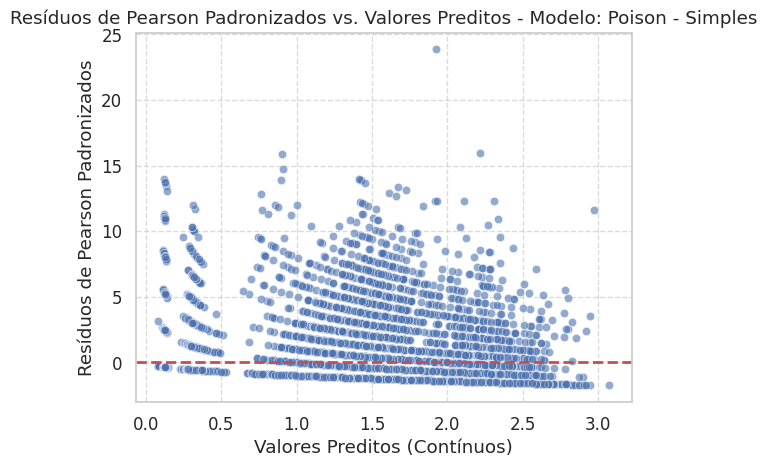

In [27]:
overdisp_plot(modelo_poison_simple, 'Poison - Simples')

Os residuos apresentam um padrão de dispersão centralizados em cada valor predito, evidencia também que a dispersão entre os valores é muito grande. Essa variância não constante é evidencia técnica de superdispersão.

In [28]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson(), error='ignore').fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14338
Model Family:                 Poisson   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16778.
Date:                Fri, 15 Aug 2025   Deviance:                       23737.
Time:                        20:31:01   Pearson chi2:                 5.27e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.7803
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  686.4243     19.963     34.384      0.000     647.297     725.552
transactions                 0.3820      0.010     39.876      0.000       0.363       0.401
median_amount              -14.1299      2.058     -6.867      0.000     -18.163     -10.097
max_amount                   0.0192      0.022      0.892      0.373      -0.023       0.061
min_current_age             -0.0719      0.006    -11.160      0.000      -0.085      -0.059
median_current_age          -0.0094      0.017     -0.552      0.581      -0.043       0.024
max_current_age              0.0008      0.006      0.132      0.895      -0.011       0.013
min_per_capita_income        0.0245      0.006      3.884      0.000       0.012       0.037
median_per_capita_income     0.1345      0.030      4.536      0.000       0.076       0.193
max_per_capita_income       -0.0015      0.000     -4.249      0.000      -0.002      -0.001
min_total_debt               0.1134      0.056      2.016      0.044       0.003       0.224
median_total_debt            0.0122      0.006      2.112      0.035       0.001       0.023
min_credit_score             1.0621      0.135      7.853      0.000       0.797       1.327
median_credit_score         -1.6110      0.378     -4.256      0.000      -2.353      -0.869
max_credit_score            -0.3995      0.934     -0.428      0.669      -2.229       1.430
min_num_credit_cards        -0.6225      0.861     -0.723      0.470      -2.311       1.066
median_num_credit_cards      1.5064      0.182      8.294      0.000       1.150       1.862
max_num_credit_cards        -0.0225      0.027     -0.849      0.396      -0.075       0.029
median_credit_limit         -0.1178      0.026     -4.561      0.000      -0.168      -0.067
max_credit_limit            -0.0001      0.000     -0.347      0.729      -0.001       0.001
target_city_0             -245.9518      6.127    -40.139      0.000    -257.961    -233.942
target_city_1              111.0163     31.854      3.485      0.000      48.583     173.450
target_description_0      -438.6180     17.607    -24.912      0.000    -473.127    -404.109
target_description_2        40.1647     33.937      1.184      0.237     -26.350     106.679
previous_frauds              1.9333      0.020     95.318      0.000       1.894       1.973
============================================================================================
"""

In [29]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.005      
Dependent Variable:     ystar            AIC:                         124130.2167
Date:                   2025-08-15 20:31 BIC:                         124137.7891
No. Observations:       14363            Log-Likelihood:              -62064.    
Df Model:               1                F-statistic:                 70.79      
Df Residuals:           14362            Prob (F-statistic):          4.34e-17   
R-squared (uncentered): 0.005            Scale:                       331.76     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.7208         0.0857       8.4139       0.0000       0.5529    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

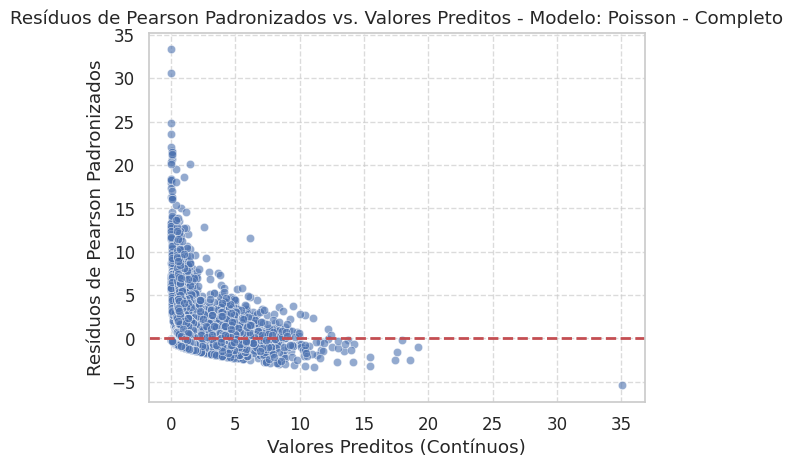

In [30]:
overdisp_plot(modelo_poison_complete, 'Poisson - Completo')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

In [31]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_capita_income') + Q('min_total_debt') + Q('median_total_debt') + Q('min_credit_score') + Q('median_credit_score') + Q('max_credit_score') + Q('min_num_credit_cards') + Q('median_num_credit_cards') + Q('max_num_credit_cards') + Q('median_credit_limit') + Q('max_credit_limit') + Q('target_city_0') + Q('target_city_1') + Q('target_description_0') + Q('target_description_2') + Q('previous_frauds')

 Family type...: 
 Poisson

 Discarding atribute "Q('max_current_age')" with p-value equal to 0.8949385644477201 

Estimating model...: 
 frauds ~ Q('transactions') + Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_capita_income') +

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14346
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16780.
Date:                Fri, 15 Aug 2025   Deviance:                       23741.
Time:                        20:31:03   Pearson chi2:                 5.27e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.7802
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       695.5628     16.013     43.438      0.000     664.179     726.947
Q('transactions')                 0.3789      0.008     49.947      0.000       0.364       0.394
Q('median_amount')              -14.0773      1.879     -7.494      0.000     -17.759     -10.395
Q('min_current_age')             -0.0723      0.006    -12.541      0.000      -0.084      -0.061
Q('min_per_capita_income')        0.0242      0.006      3.879      0.000       0.012       0.036
Q('median_per_capita_income')     0.1280      0.029      4.477      0.000       0.072       0.184
Q('max_per_capita_income')       -0.0015      0.000     -4.514      0.000      -0.002      -0.001
Q('min_total_debt')               0.1040      0.027      3.923      0.000       0.052       0.156
Q('median_total_debt')            0.0142      0.005      2.714      0.007       0.004       0.024
Q('min_credit_score')             1.0468      0.132      7.910      0.000       0.787       1.306
Q('median_credit_score')         -1.6314      0.377     -4.330      0.000      -2.370      -0.893
Q('median_num_credit_cards')      1.4552      0.166      8.777      0.000       1.130       1.780
Q('median_credit_limit')         -0.1140      0.025     -4.602      0.000      -0.163      -0.065
Q('target_city_0')             -246.1238      6.091    -40.406      0.000    -258.062    -234.185
Q('target_city_1')              107.5376     31.710      3.391      0.001      45.388     169.687
Q('target_description_0')      -451.7920     14.405    -31.364      0.000    -480.025    -423.559
Q('previous_frauds')              1.9331      0.020     95.766      0.000       1.894       1.973
=================================================================================================
"""

In [32]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.005      
Dependent Variable:     ystar            AIC:                         124059.2534
Date:                   2025-08-15 20:31 BIC:                         124066.8258
No. Observations:       14363            Log-Likelihood:              -62029.    
Df Model:               1                F-statistic:                 71.16      
Df Residuals:           14362            Prob (F-statistic):          3.60e-17   
R-squared (uncentered): 0.005            Scale:                       330.13     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.7215         0.0855       8.4358       0.0000       0.5538    

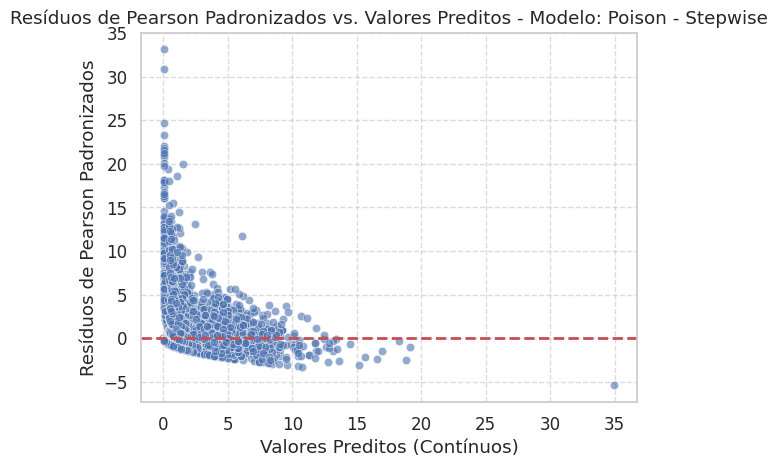

In [33]:
overdisp_plot(modelo_poisson_stepswise, 'Poison - Stepwise')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

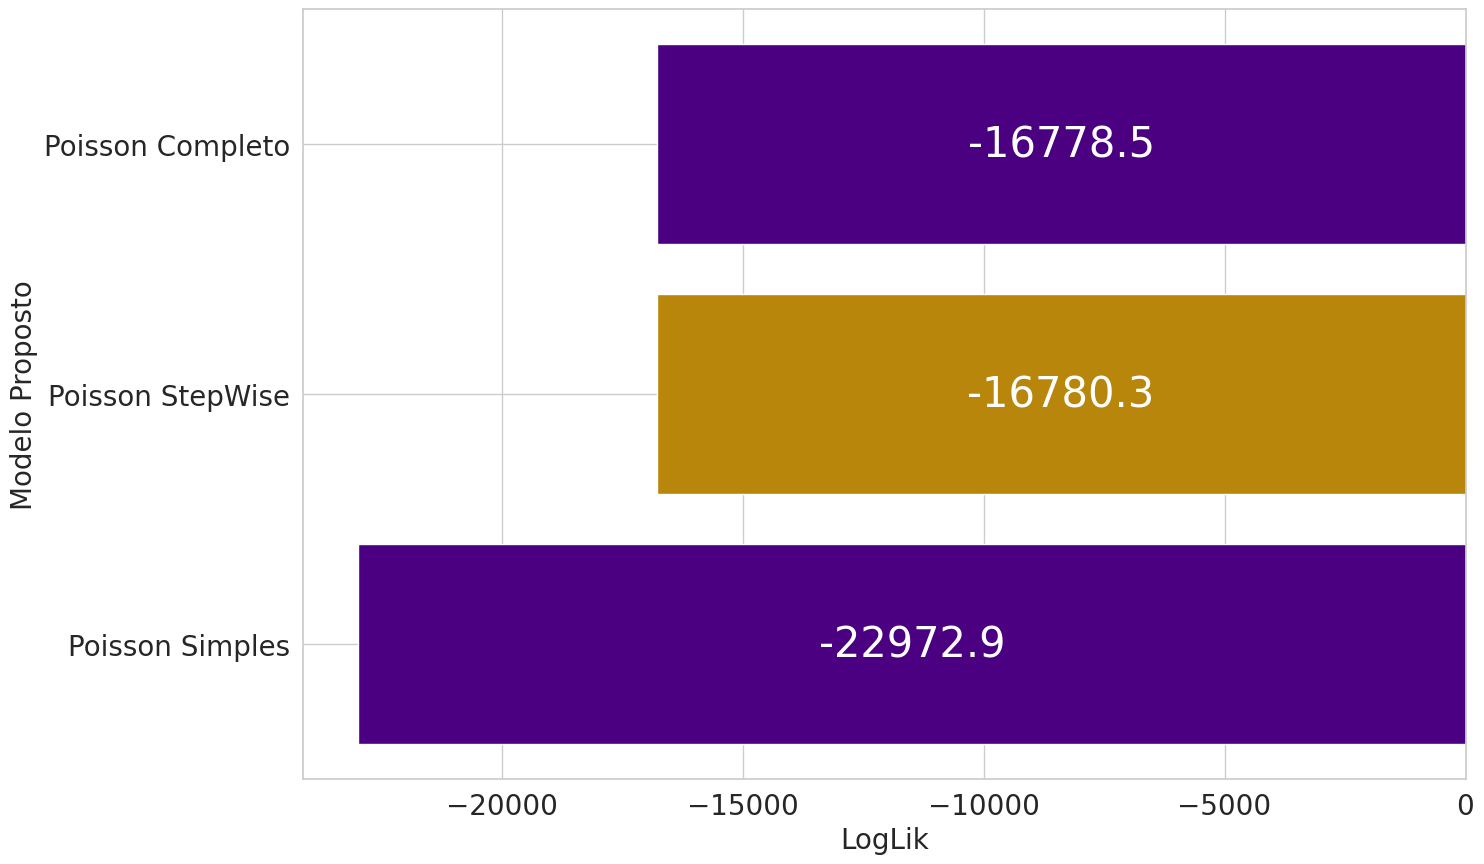

In [34]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida, conforme discutido no capítulo "Modelos de Regressão para Dados de Contagem" do manual.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.

---

### Quando Utilizar

- Dados de contagem com variância > média.
- Cenários onde o modelo de Poisson apresenta sobredispersão detectada via testes estatísticos.
- Alternativa robusta ao Poisson, sem necessidade de recorrer a modelos com inflação de zeros ou estruturas mais complexas.

---

**Nota:** A orientação para uso e interpretação desses modelos, incluindo verificação de sobredispersão, seleção de variáveis e diagnóstico de modelo, segue os princípios estabelecidos no capítulo 14 do manual.


In [35]:
result_tests = {}
for column in X.drop(columns=['frauds'], errors='ignore').columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [36]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14361
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16694.
Date:                Fri, 15 Aug 2025   Deviance:                       18553.
Time:                        20:31:05   Pearson chi2:                 4.60e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2556
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8098      0.017    -47.144      0.000      -0.843      -0.776
previous_frauds     1.6713      0.027     62.337      0.000       1.619       1.724
===================================================================================
"""

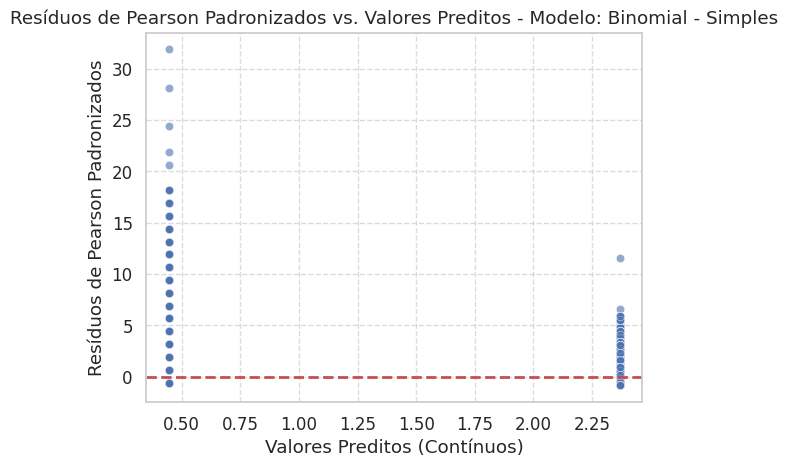

In [37]:
overdisp_plot(modelo_binomialneg_simples, 'Binomial - Simples')

Os residuos apresentam um padrão de dispersão centralizados em cada valor predito, evidencia também que a dispersão entre os valores é muito grande. Essa variância não constante é evidencia técnica de superdispersão.

In [38]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14338
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13518.
Date:                Fri, 15 Aug 2025   Deviance:                       12200.
Time:                        20:31:08   Pearson chi2:                 3.50e+04
No. Iterations:                    69   Pseudo R-squ. (CS):             0.5217
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1088.9314     40.359     26.981      0.000    1009.829    1168.033
transactions                 0.3639      0.014     25.623      0.000       0.336       0.392
median_amount              -21.2470      3.099     -6.857      0.000     -27.320     -15.174
max_amount                  -0.0135      0.039     -0.348      0.728      -0.089       0.062
min_current_age             -0.0520      0.010     -4.965      0.000      -0.073      -0.031
median_current_age          -0.0090      0.026     -0.350      0.727      -0.060       0.042
max_current_age              0.0024      0.009      0.281      0.778      -0.014       0.019
min_per_capita_income        0.0199      0.008      2.438      0.015       0.004       0.036
median_per_capita_income     0.1387      0.046      3.023      0.003       0.049       0.229
max_per_capita_income       -0.0019      0.001     -3.223      0.001      -0.003      -0.001
min_total_debt               0.2003      0.078      2.556      0.011       0.047       0.354
median_total_debt            0.0263      0.009      2.970      0.003       0.009       0.044
min_credit_score             1.2010      0.173      6.937      0.000       0.862       1.540
median_credit_score         -1.4106      0.568     -2.483      0.013      -2.524      -0.297
max_credit_score            -1.8381      0.951     -1.932      0.053      -3.703       0.026
min_num_credit_cards        -1.5204      1.440     -1.056      0.291      -4.344       1.303
median_num_credit_cards      1.5630      0.277      5.637      0.000       1.020       2.106
max_num_credit_cards         0.0218      0.042      0.517      0.605      -0.061       0.104
median_credit_limit         -0.1115      0.040     -2.793      0.005      -0.190      -0.033
max_credit_limit            -0.0010      0.001     -1.379      0.168      -0.002       0.000
target_city_0             -531.5077     19.185    -27.704      0.000    -569.110    -493.906
target_city_1               11.1216     72.362      0.154      0.878    -130.705     152.948
target_description_0      -546.2669     33.448    -16.332      0.000    -611.824    -480.710
target_description_2        49.9930     65.090      0.768      0.442     -77.581     177.567
previous_frauds              1.9968      0.034     58.737      0.000       1.930       2.063
============================================================================================
"""

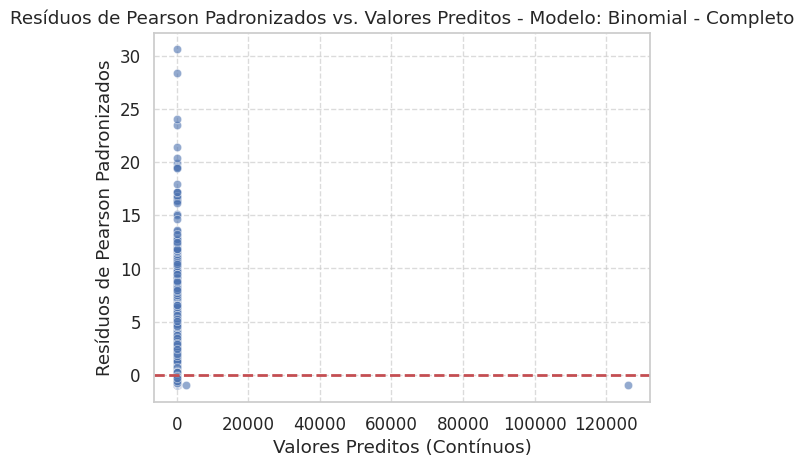

In [39]:
overdisp_plot(modelo_binomialneg_completo, 'Binomial - Completo')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

In [40]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transactions') + Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income') + Q('max_per_capita_income') + Q('min_total_debt') + Q('median_total_debt') + Q('min_credit_score') + Q('median_credit_score') + Q('max_credit_score') + Q('min_num_credit_cards') + Q('median_num_credit_cards') + Q('max_num_credit_cards') + Q('median_credit_limit') + Q('max_credit_limit') + Q('target_city_0') + Q('target_city_1') + Q('target_description_0') + Q('target_description_2') + Q('previous_frauds')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('target_city_1')" with p-value equal to 0.8778505947895338 

Estimating model...: 
 frauds ~ Q('transactions') + Q('median_amount') + Q('max_amount') + Q('min_current_age') + Q('median_current_age') + Q('max_current_age') + Q('min_per_capita_income') + Q('median_per_capita_income')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                14363
Model:                            GLM   Df Residuals:                    14347
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13522.
Date:                Fri, 15 Aug 2025   Deviance:                       12208.
Time:                        20:31:15   Pearson chi2:                 3.53e+04
No. Iterations:                    52   Pseudo R-squ. (CS):             0.5215
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      1078.5948     34.230     31.510      0.000    1011.506    1145.684
Q('transactions')                 0.3583      0.011     32.935      0.000       0.337       0.380
Q('median_amount')              -22.1465      2.831     -7.822      0.000     -27.696     -16.597
Q('min_current_age')             -0.0546      0.009     -5.749      0.000      -0.073      -0.036
Q('min_per_capita_income')        0.0215      0.008      2.676      0.007       0.006       0.037
Q('median_per_capita_income')     0.1230      0.044      2.814      0.005       0.037       0.209
Q('max_per_capita_income')       -0.0021      0.001     -3.653      0.000      -0.003      -0.001
Q('min_total_debt')               0.1929      0.030      6.441      0.000       0.134       0.252
Q('median_total_debt')            0.0290      0.008      3.571      0.000       0.013       0.045
Q('min_credit_score')             1.1989      0.170      7.062      0.000       0.866       1.532
Q('median_credit_score')         -1.4157      0.565     -2.505      0.012      -2.523      -0.308
Q('median_num_credit_cards')      1.5441      0.252      6.126      0.000       1.050       2.038
Q('median_credit_limit')         -0.1135      0.038     -2.962      0.003      -0.189      -0.038
Q('target_city_0')             -532.7961     18.587    -28.666      0.000    -569.225    -496.367
Q('target_description_0')      -551.4184     27.853    -19.797      0.000    -606.010    -496.827
Q('previous_frauds')              1.9967      0.034     58.932      0.000       1.930       2.063
=================================================================================================
"""

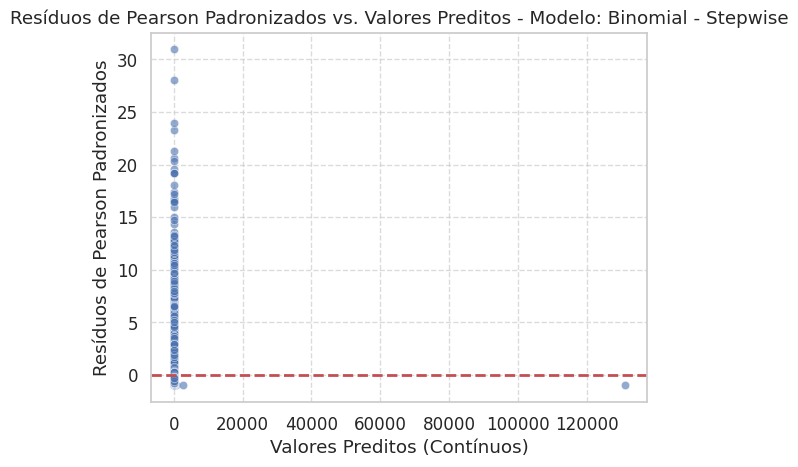

In [41]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial - Stepwise')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão.

In [42]:
lrtest([modelo_binomialneg_completo, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -7.78
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


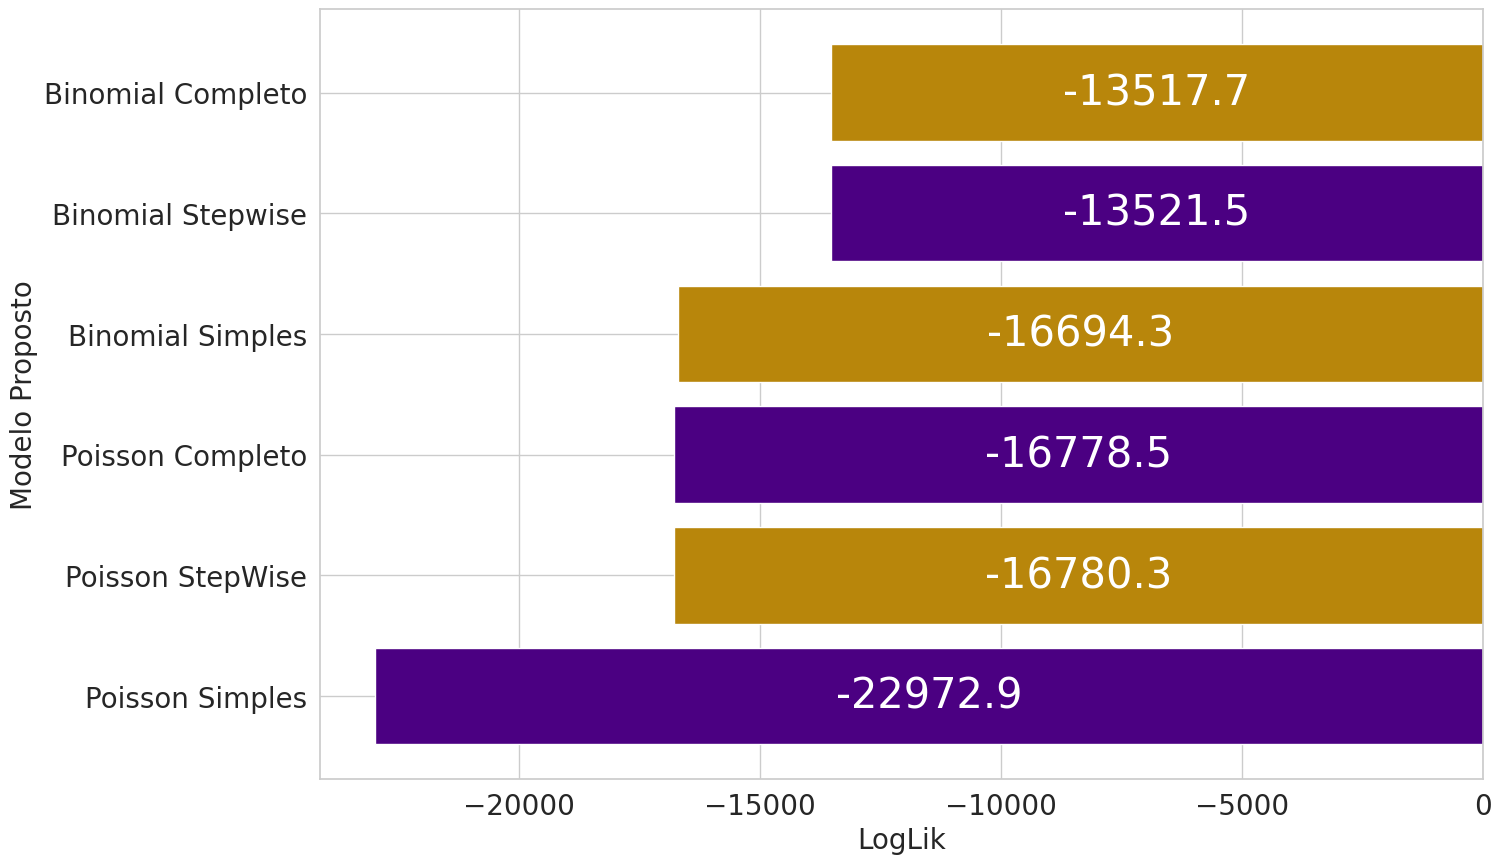

In [43]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.


In [44]:
result_tests = {}
for column in X.drop(columns=['frauds']).columns:
  X1 = X[column].copy()
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
  result_tests[column] = modelo_zip_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'transactions'

In [45]:
X1 = X[column_max].copy()
X1 = sm.add_constant(X1)

In [46]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14361
Method:                            MLE   Df Model:                            1
Date:                 Fri, 15 Aug 2025   Pseudo R-squ.:                 0.08979
Time:                         20:31:21   Log-Likelihood:                -15224.
converged:                        True   LL-Null:                       -16726.
Covariance Type:                   HC1   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_const            2.3292      0.059     39.558      0.000       2.214       2.445
inflate_transactions    -0.1945      0.007    -26.111      0.000      -0.209      -0.180
const                   -0.1620      0.050     -3.254      0.001      -0.260      -0.064
transactions             0.1774      0.006     29.940      0.000       0.166       0.189
========================================================================================
"""

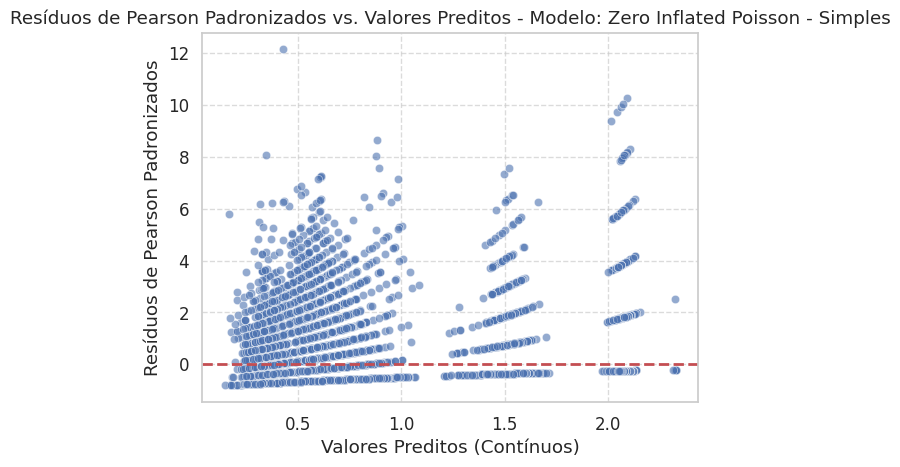

In [47]:
overdisp_plot(modelo_zip_simples, 'Zero Inflated Poisson - Simples')

A dispersão presentes entre os valores preditos demonstra um padrão de cone evidenciando um problema de superdispersão porém o modelo ZIP conseguiu identificar a quantidade de zeros ao contrário do modelo ZIP

In [48]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 1.599453
         Iterations 7
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -39.525
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [49]:
X1 = X.copy()
X1 = sm.add_constant(X1)

In [50]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                14363
Model:             ZeroInflatedPoisson   Df Residuals:                    14337
Method:                            MLE   Df Model:                           25
Date:                 Fri, 15 Aug 2025   Pseudo R-squ.:                  0.2415
Time:                         20:31:23   Log-Likelihood:                -12687.
converged:                       False   LL-Null:                       -16726.
Covariance Type:                   HC1   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
inflate_const                        0.0954    137.624      0.001      0.999    -269.642     269.833
inflate_transactions                 0.0637      0.048      1.339      0.181      -0.030       0.157
inflate_frauds                       0.0820      0.023      3.544      0.000       0.037       0.127
inflate_median_amount                0.0997      3.820      0.026      0.979      -7.387       7.587
inflate_max_amount                   0.0954      0.174      0.549      0.583      -0.245       0.436
inflate_min_current_age             -0.0157      0.074     -0.213      0.832      -0.161       0.129
inflate_median_current_age          -0.1515      0.120     -1.258      0.208      -0.388       0.085
inflate_max_current_age             -0.3639      0.052     -7.031      0.000      -0.465      -0.262
inflate_min_per_capita_income        0.0991      0.035      2.857      0.004       0.031       0.167
inflate_median_per_capita_income    -0.0110      0.115     -0.096      0.924      -0.237       0.215
inflate_max_per_capita_income       -0.5101      0.002   -247.693      0.000      -0.514      -0.506
inflate_min_total_debt               0.0975      0.250      0.389      0.697      -0.393       0.588
inflate_median_total_debt           -0.1751      0.039     -4.437      0.000      -0.252      -0.098
inflate_min_credit_score             0.0773      1.324      0.058      0.953      -2.518       2.673
inflate_median_credit_score          0.0668      1.582      0.042      0.966      -3.033       3.167
inflate_max_credit_score             0.0604      8.065      0.007      0.994     -15.747      15.868
inflate_min_num_credit_cards         0.0956      4.191      0.023      0.982      -8.119       8.310
inflate_median_num_credit_cards      0.0821      1.356      0.061      0.952      -2.576       2.740
inflate_max_num_credit_cards         0.0593      0.137      0.434      0.664      -0.209       0.327
inflate_median_credit_limit          0.0266      0.160      0.166      0.868      -0.287       0.340
inflate_max_credit_limit            -0.4345      0.002   -182.605      0.000      -0.439      -0.430
inflate_target_city_0                0.0954     66.574      0.001      0.999    -130.388     130.578
inflate_target_city_1                0.1000     76.616      0.001      0.999    -150.064     150.264
inflate_target_description_0         0.0954     71.736      0.001      0.999    -140.505     140.695
inflate_target_description_2         0.1000    119.202      0.001      0.999    -233.531     233.731
inflate_previous_frauds              0.0975      0.287      0.340      0.734      -0.465       0.660
const                               -0.2439    126.405     -0.002      0.998    -247.992     247.505
transactions                         0.2115      0.017     12.679      0.000       0.179       0.244
frauds                               0.1681      0.018      9.329      0.000       0.133       0.203


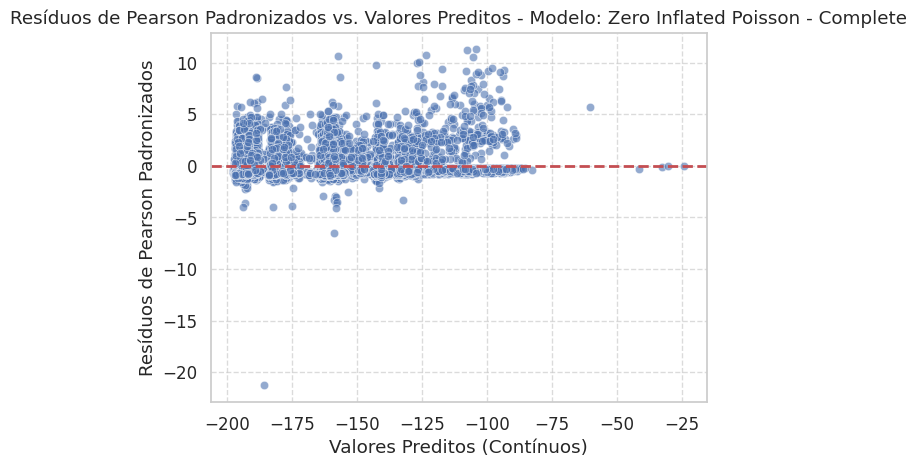

In [51]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson - Complete')

O modelo conseguiu identificar bem a questão de inflação de zeros mas não conseguiu lidar com a superdispersão dos dados para os outros targets com uma variancia muito alta.

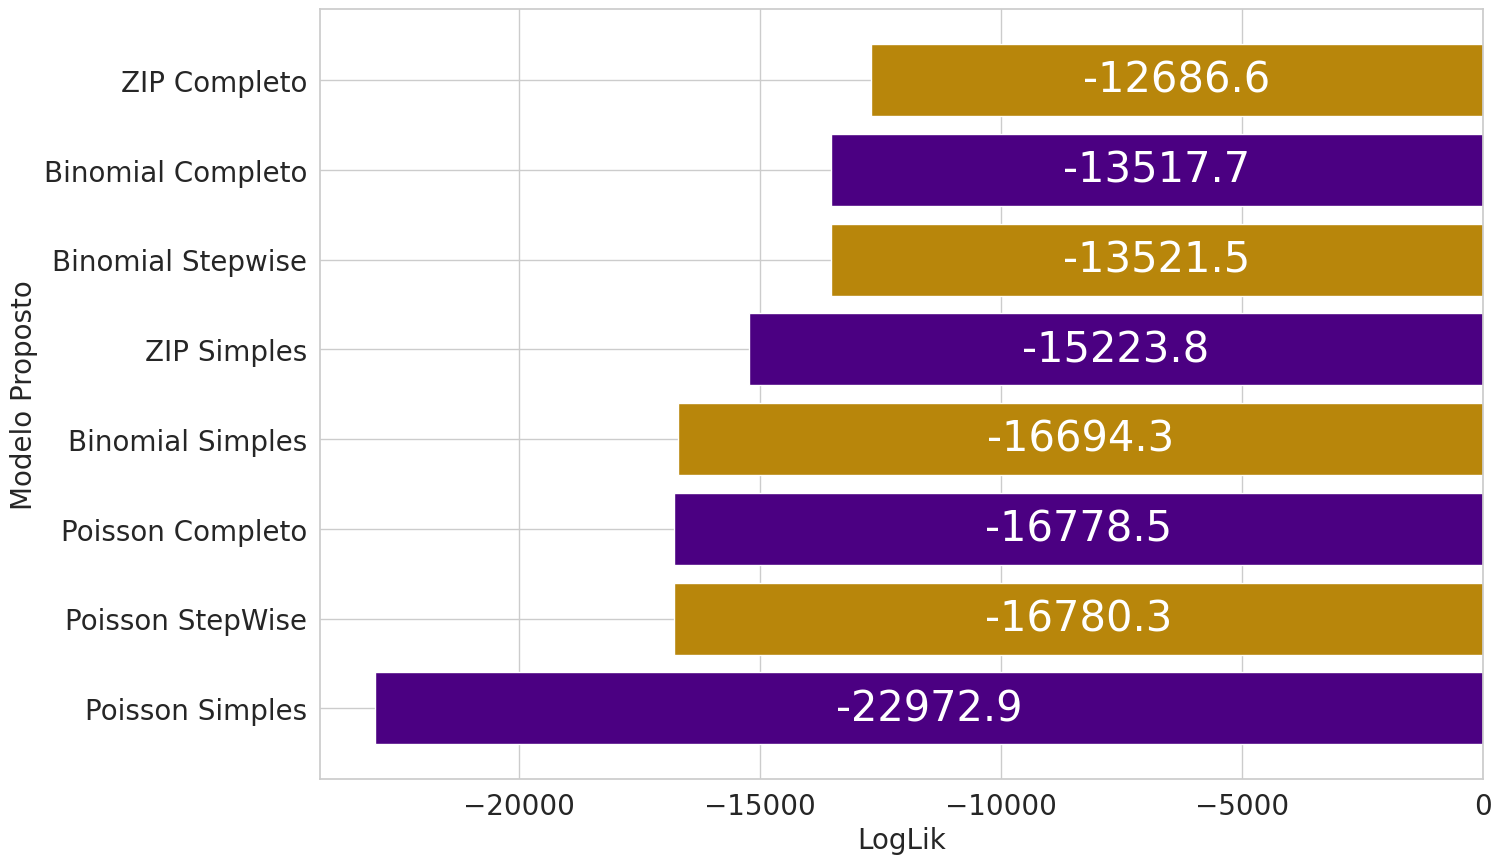

In [52]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [53]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='LLF',
    cov_type='HC1',
    verbose=False,
)
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=42)
random_selector.fit(X, y)

NameError: name 'RandomFeatureSelector' is not defined

In [ ]:
modelo_zip_stepwise = random_selector.best_estimator_.final_model_

In [ ]:
modelo_zip_stepwise.summary()

In [ ]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson - Stepwise')

In [ ]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

In [ ]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf
      ]
})

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


In [ ]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
  result_tests[column] = modelo_zbneg_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

In [ ]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [ ]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zinb_simples.summary()

In [ ]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Bneg - Simples')

In [ ]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

In [ ]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [ ]:
modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False, cov_type='HC1')
modelo_zinb_complete.summary()

In [ ]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Bneg - Completo')

In [ ]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    verbose=False,
    cov_type='HC1'
)
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=42)
random_selector.fit(X_scaler, y)

In [ ]:
modelo_zinb_stepwise = random_selector.best_estimator_.final_model_
modelo_zinb_stepwise.summary()

In [ ]:
del random_selector, step_wise

In [ ]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Bneg - Stepwise')

## Métricas e Comparação

### Log Lik

In [ ]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_stepwise.llf
      ]
})

### Residuos padronizados x Valores preditos

In [ ]:
titles = [
    'Poisson Simples',
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Simples',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Simples',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Simples',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_stepwise
]

In [ ]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 3, i + 1)
    overdisp_plot(model, titles[i], "{}")

plt.tight_layout()
plt.show()

In [ ]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic, Converged=model.converged)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

### Tabela de Métricas

In [ ]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by=['LLF', 'Converged'], ascending=False).reset_index(drop=True)

### Comparação de Métricas entre modelos

In [ ]:
df_metrics.query('Converged == True', inplace=True)

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['title']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['title']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='title', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['title']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['title']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['title']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

### Seleção do modelo e identificação das features

In [ ]:
best_model_llf

In [ ]:
indice = titles.index(best_model_llf)
best_model = models[indice]
best_model.summary()

In [ ]:
def generate_playload(df_features_model, data: pd.DataFrame):
  exog = df_features_model[df_features_model['component'] == 'count']['feature'].to_list()
  exog_infl = df_features_model[df_features_model['component'] == 'classification']['feature'].to_list()

  data_exog = data[[ex for ex in exog if ex in data.columns]]
  data_exog_infl = data[[ex for ex in exog_infl if ex in data.columns]]

  sm.add_constant(data_exog)
  sm.add_constant(data_exog_infl)

  return data_exog, data_exog_infl


In [ ]:
df_features_model = pd.merge(best_model.params.rename('coefficients'),
         best_model.pvalues.rename('p_value'),
         how='inner',
         left_index=True,
         right_index=True) \
  .assign(component=lambda data: ['classification' if 'inflate_' in index else 'count' for index in data.index.to_list()]) \
  .assign(feature=lambda data: [index.replace('inflate_', '') for index in data.index.to_list()]) \
  .sort_values(by='component').reset_index(drop=True)[['feature', 'component', 'coefficients', 'p_value']]
# df_features_model['interpretation'] = np.exp(df_features_model['coefficients'])
df_features_model


In [ ]:
exog, exog_infl = generate_playload(df_features_model.query('feature != "alpha" or feature != "const"'), df)
exog

In [ ]:
df.describe().T

### Análise do modelo para validar aspectos relevantes

In [ ]:
features_df = best_model.model.exog
feature_names = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
df_features = pd.DataFrame(features_df, columns=feature_names)
df_features['residuos'] = best_model.resid_pearson
df_features['fitted'] = best_model.fittedvalues
df_features

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_features["residuos"], bins=50, kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos Padronizados")
plt.xlabel("Resíduos Padronizados")
plt.ylabel("Frequência")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
sm.qqplot(df_features["residuos"], line='45', fit=True)
plt.title("QQ-Plot dos Resíduos Padronizados")
plt.tight_layout()
plt.show()

In [ ]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df_features["residuos"])
print(f"[Shapiro-Wilk] Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")

In [ ]:
# D’Agostino and Pearson's test
dagostino_stat, dagostino_p = stats.normaltest(df_features["residuos"])
print(f"[D’Agostino] Estatística: {dagostino_stat:.4f} | p-valor: {dagostino_p:.4f}")

In [ ]:
# Teste de Heterocedasticidade (Breusch-Pagan)
X = sm.add_constant(df_features["fitted"])
model_bp = sm.OLS(df_features["residuos"], X).fit()
bp_test = het_breuschpagan(model_bp.resid, X)
bp_labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']
print("\n[Breusch-Pagan]")
for label, val in zip(bp_labels, bp_test):
    print(f"{label}: {val:.4f}")

In [ ]:
# Teste de Autocorrelação (Durbin-Watson)
dw_stat = durbin_watson(df_features["residuos"])
print(f"\n[Durbin-Watson] Estatística: {dw_stat:.4f}")

In [ ]:
# Estilo mais profissional e consistente
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

# Paleta de cores
point_color = "#1f77b4"  # azul elegante
line_color = "#d62728"   # vermelho para linha horizontal

# Seleciona colunas para análise
cols_plot = [c for c in df_features.columns if c.lower() not in ['intercept', 'const', 'residuos']]

# Número total de gráficos
n_plots = len(cols_plot) + 1  # +1 para incluir o de valores ajustados
n_rows = (n_plots + 1) // 2   # duas colunas

# Cria figura e eixos
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))
axes = axes.flatten()

# 1) Resíduos vs. variáveis explicativas
for i, col in enumerate(cols_plot):
    sns.scatterplot(data=df_features, x=col, y='residuos',
                    s=50, alpha=0.7, edgecolor="k", color=point_color, ax=axes[i])
    axes[i].axhline(0, linestyle='--', color=line_color, linewidth=1.2)
    axes[i].set_title(f"Análise de Resíduos vs. {col}", fontsize=14, weight="bold")
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Resíduos", fontsize=12)

# 2) Resíduos vs. Valores Ajustados
idx = len(cols_plot)
sns.scatterplot(x=df_features['fitted'], y=df_features['residuos'],
                s=50, alpha=0.7, edgecolor="k", color=point_color, ax=axes[idx])
axes[idx].axhline(0, linestyle='--', color=line_color, linewidth=1.2)
axes[idx].set_title("Análise de Resíduos vs. Valores Ajustados", fontsize=14, weight="bold")
axes[idx].set_xlabel("Valores Ajustados (Fitted)", fontsize=12)
axes[idx].set_ylabel("Resíduos", fontsize=12)

# Remove eixos extras se sobrar espaço
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
X_sample_adjusting = X_scaler.sample(5, random_state=42)
X_sample_adjusting

In [ ]:
def generate_playload(df_features_model, data: pd.DataFrame):
  exog = df_features_model[df_features_model['component'] == 'count']['feature'].to_list()
  exog_infl = df_features_model[df_features_model['component'] == 'classification']['feature'].to_list()

  data_exog = data[[ex for ex in exog if ex in data.columns]]
  data_exog_infl = data[[ex for ex in exog_infl if ex in data.columns]]

  sm.add_constant(data_exog)
  sm.add_constant(data_exog_infl)

  return data_exog, data_exog_infl


In [ ]:
exog, exog_infl = generate_playload(df_features_model.query('feature != "alpha" or feature != "const"'), X_sample_adjusting)

In [ ]:
exog

In [ ]:
[round(pred) for pred in best_model.predict(exog=exog.values, exog_infl=exog_infl.values)]

In [ ]:
y.loc[X_sample_adjusting.index]

In [ ]:
import time

while True:
  time.sleep(60)
  print('ZzzZzz')